# 提升树 Adaboost Decision Tree
## 算法实现 implementation of algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split

### 数据集 Dataset

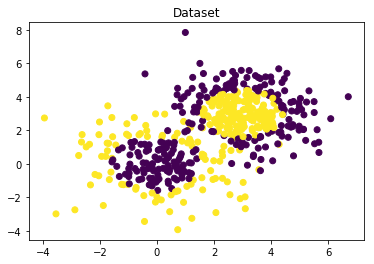

In [2]:
X1, y1 = make_gaussian_quantiles(cov=2.,n_samples=200, n_features=2,n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5, n_samples=300, n_features=2, n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))
y[y==0]=-1
X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Dataset")
plt.show()

### 弱分类器：决策树桩 weakly learnable classifier : decision stump

In [3]:
class DecisionStump():
    def __init__(self):
        # 树结构参考 06-分类决策树
        self.tree = {'feature':None,'threshold':None,'left_child':None,'right_child':None}
    
    def train(self, X_train, y_train, weights, step_number=10):
        n_samples, n_features = X_train.shape
        min_error = np.inf
        # 遍历特征
        for i in range(n_features):
            self.tree['feature'] = i
            min_value = X_train[:, i].min()
            max_value = X_train[:, i].max()
            step_size = (max_value - min_value) / float(step_number)
            # 按步长设定阈值
            for j in range(-1, step_number + 1):
                self.tree['threshold'] = min_value + j * step_size
                for leaf in range(n_features):
                    # 二分类
                    self.tree['left_child'] = -1 if leaf == 0 else 1
                    self.tree['right_child'] = 1 if leaf == 0 else -1
                    y_p = [self.predict(x) for x in X_train]
                    # is_error 是否错误的标记
                    is_error = np.ones((n_samples,))
                    is_error[y_p == y_train] = 0
                    # 损失乘以归一化的权重
                    weighted_error = np.dot(weights.T, is_error)
                    if weighted_error < min_error:
                        min_error = weighted_error.copy()
                        prediction = y_p.copy()
                        stump = self.tree.copy()
        return prediction, stump, min_error
    
    def predict(self, X_test, node=None):
        if node is None:
            node = self.tree
        feature = node['feature']
        threshold = node['threshold']
        if X_test[feature] < threshold:
            if isinstance(node['left_child'], (int, np.integer)):
                return node['left_child']
            else:
                prediction = self.predict(X_test, node['left_child'])
        elif X_test[feature] >= threshold:
            if isinstance(node['right_child'], (int, np.integer)):
                return node['right_child']
            else:
                prediction = self.predict(X_test, node['right_child'])
        return prediction

In [4]:
class Adaboost():
    def __init__(self):
        self.weights = []
        self.tree_list = []
    
    def fit(self, X_train, y_train, n_iters):
        n_samples, n_features = X_train.shape
        data_weights = np.ones((n_samples,)) / n_samples
        clf = DecisionStump()
        for i in range(n_iters):
            prediction, stump, weighted_error = clf.train(X_train, y_train, data_weights)
            self.tree_list.append(stump)
            w = 0.5 * np.log((1.0 - weighted_error) / max(weighted_error, 1e-16))
            self.weights.append(w)
            data_weights = data_weights * np.exp(-1.0 * self.weights[i] * y_train * prediction)
            data_weights = data_weights / np.sum(data_weights)
    
    def predict(self, X_test):
        n_samples, n_features = X_test.shape
        clf = DecisionStump()
        prediction = np.zeros((n_samples,),dtype=np.float64)
        for i in range(len(self.tree_list)):
            step_prediction = np.array([clf.predict(x, self.tree_list[i]) for x in X_test])
            prediction += self.weights[i] * step_prediction
        return np.sign(prediction)

In [5]:
clf = Adaboost()
clf.fit(X_train,y_train,40)
y_p_train = clf.predict(X_train)
train_acc = np.sum(y_p_train == y_train)/len(y_p_train) * 100
print(f"Train accuracy from scratch: {format(train_acc)}%")
y_p_test = clf.predict(X_test)
test_acc = np.sum(y_p_test == y_test)/len(y_p_test) * 100
print(f"Test accuracy from scratch: {format(test_acc)}%")

Train accuracy from scratch: 84.8%
Test accuracy from scratch: 82.39999999999999%


### 决策边界可视化 Visualize decision boundary

In [6]:
def plot_decision_boundary(clf, X, y): 
    # Plotting decision regions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z =  np.array(clf.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    from matplotlib.colors import ListedColormap
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, Z, cmap=cmap_light)

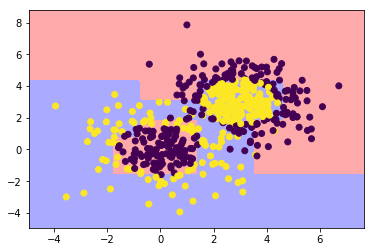

In [7]:
plot_decision_boundary(clf, X, y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

## scikit-learn

In [8]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [9]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm='SAMME', n_estimators=40)
bdt.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=40, random_state=None)

In [10]:
train_acc1 =  bdt.score(X_train,y_train)
test_acc1 = bdt.score(X_test,y_test)
print(f"Train accuracy from scratch: {train_acc1 * 100}%")
print(f"Test accuracy from scratch: {test_acc1 * 100}%")

Train accuracy from scratch: 89.06666666666668%
Test accuracy from scratch: 76.8%


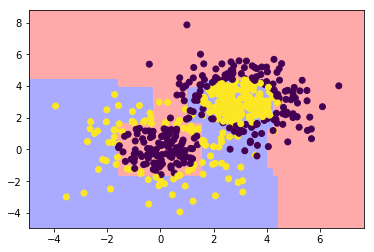

In [11]:
plot_decision_boundary(bdt, X, y)
plt.scatter(X[:,0], X[:,1], c=y)
plt.show()